# Part 1
ImageNet dataset - AlexNet
MNIST dataset - LeNet-5

In [1]:
# Import essential modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.nn import Module
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt



/Users/maggie/anaconda3/envs/EML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#TODO: Define AlexNet Network


In [3]:
#TODO: Load and Visialize ImageNet dataloader


In [4]:
#TODO: Load Pre-trained Best Model parameters

In [5]:
#TODO: Display Un-pruned evaluation results

In [33]:
# Define LeNet-5 Network
import sys
sys.path.append('./src')
from LeNet_5 import LeNet5
model_LeNet = LeNet5()

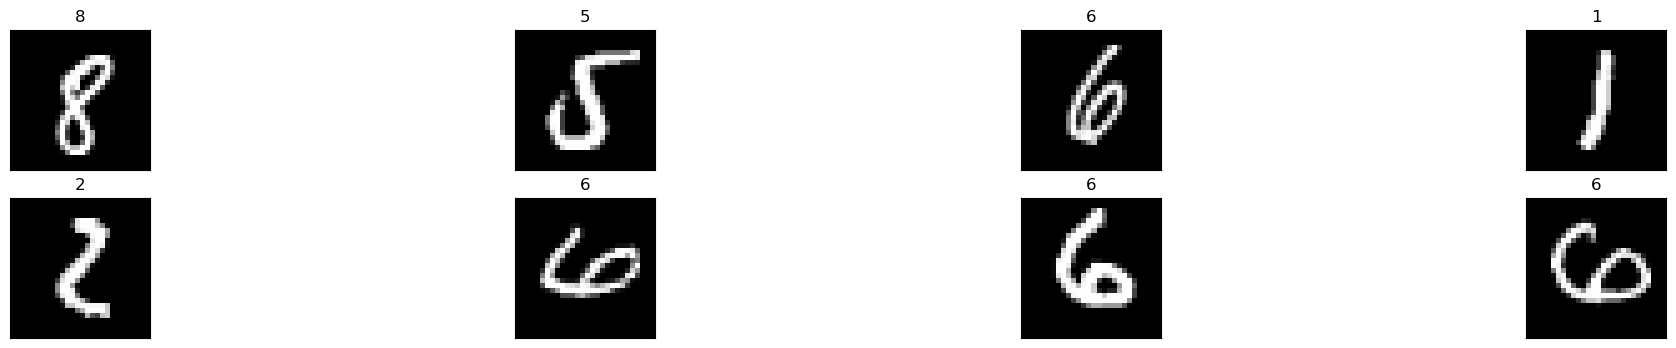

In [7]:
# Load and Visialize MNIST dataloader
batch_size = 256

train_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

plt.show()

Epoch 5 - Training loss: 0.0544
Epoch 10 - Training loss: 0.0282
Epoch 15 - Training loss: 0.0170
Epoch 20 - Training loss: 0.0106
Epoch 25 - Training loss: 0.0076
Epoch 30 - Training loss: 0.0055


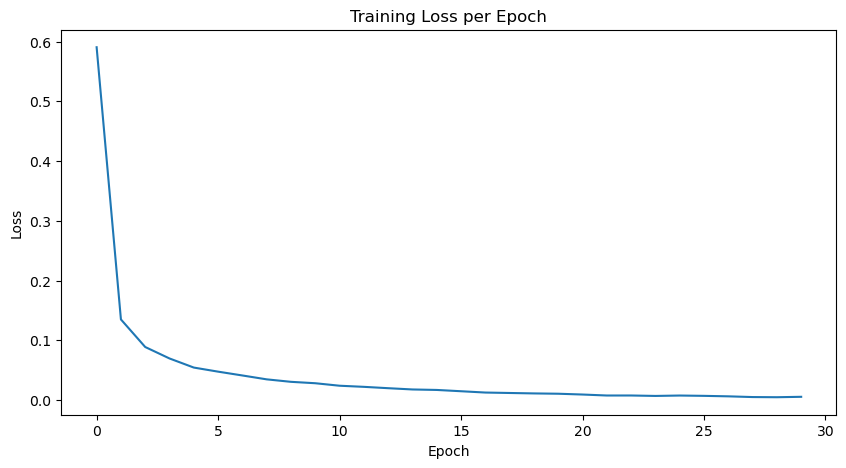

In [34]:
# Train and Load Pre-trained Best Model parameters
from SimplePruning_Toolbox import utils 
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 30
best_loss = float('inf')
losses = []

for epoch in range(epochs):
    avg_loss = utils.train(model_LeNet, 
            train_loader, 
            device, 
            optimizer = optim.Adam(model_LeNet.parameters(), 
            lr=1e-3), 
            criterion = nn.CrossEntropyLoss(), mask=None)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} - Training loss: {avg_loss:.4f}")
    losses.append(avg_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model_LeNet.state_dict(), 'best_model_LeNet.pth')
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()


In [35]:
# Display Un-pruned evaluation results
from SimplePruning_Toolbox.utils import evaluate
model_LeNet.load_state_dict(torch.load('best_model_LeNet.pth'))
test_loss, accuracy = evaluate(model_LeNet, test_loader, device, nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Original model, Test Loss: 0.0367, Accuracy: 0.9914


# Part 2:
Model Pruning

In [38]:
# Define ADMM Pruning method
from SimplePruning_Toolbox import admm_pruning
percent = [0.95, 0.95, 0.95, 0.95, 0.95]

In [ ]:
#TODO: Apply ADMM pruning method to AlexNet


In [ ]:
#TODO: Visualize model parameter changes and model size changes of AlexNet

In [ ]:
#TODO: Retrain the model of AlexNet

In [ ]:
#TODO: Compare the evluation results of AlexNet

In [42]:
# Apply ADMM pruning method to LeNet-5
model2 = LeNet5()
model2.load_state_dict(torch.load('best_model_LeNet.pth'))
pruned_model, mask = admm_pruning(model2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10
Test Loss: 2.4807, Accuracy: 0.0953
Epoch 2/10
Test Loss: 2.4344, Accuracy: 0.1876
Epoch 3/10
Test Loss: 2.2632, Accuracy: 0.2987
Epoch 4/10
Test Loss: 2.0175, Accuracy: 0.4364
Epoch 5/10
Test Loss: 1.7689, Accuracy: 0.5131
Epoch 6/10
Test Loss: 1.5305, Accuracy: 0.5891
Epoch 7/10
Test Loss: 1.3000, Accuracy: 0.6829
Epoch 8/10
Test Loss: 1.1111, Accuracy: 0.7450
Epoch 9/10
Test Loss: 0.9454, Accuracy: 0.8025
Epoch 10/10
Test Loss: 0.8230, Accuracy: 0.8411
Pruned model, Test Loss: 0.5891, Accuracy: 0.8403


Number of nonzero parameters in original model: 61706
Number of nonzero parameters in pruned model: 3310


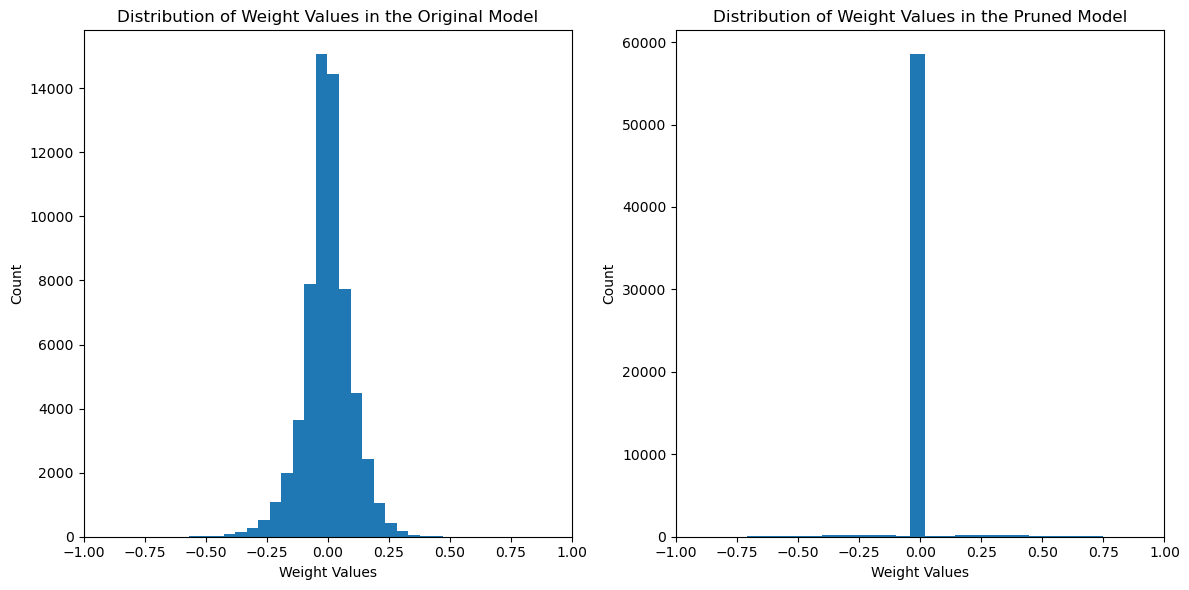

In [62]:
# Visualize model parameter changes and model size changes of LeNet-5
from SimplePruning_Toolbox.utils import count_nonzero_params
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_LeNet)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_LeNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


In [53]:
# Retrain the model of LeNet-5
fine_tune_epochs = 5
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    utils.train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask = mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Test Loss: 0.5194, Accuracy: 0.8588
Epoch: 2, Test Loss: 0.4420, Accuracy: 0.8830
Epoch: 3, Test Loss: 0.4019, Accuracy: 0.8915
Epoch: 4, Test Loss: 0.3575, Accuracy: 0.9024
Epoch: 5, Test Loss: 0.3217, Accuracy: 0.9093


Comparison of origianl and pruned LeNet-5
|  | Pretrained Model | Pruned Model | Retrained Model |
|---------|---------|---------|---------|
| Size |61706  | 3310 | 3310 |
| Accuracy | 0.9914 | 0.8403 | 0.9093 |
